# Méthodes de sélection de variables Par Lasso ou critères AIC|BIC

Ce notebook se concentre sur la sélection de modèles pour les modèles Lasso qui sont des modèles linéaires avec une pénalité L1 pour les problèmes de régression. Plusieurs stratégies peuvent être utilisées pour sélectionner la valeur du paramètre de régularisation : via une validation croisée ou en utilisant un critère d'information, à savoir AIC ou BIC.

Dans ce qui suit, nous explorerons ces différentes stratégies

ce notebook s'inspire de la source [Lasso model selection: AIC-BIC / cross-validation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html)

In [72]:
# manipulation de données
import pandas as pd
import numpy as np

# visualisation
import pylab as pl
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use('cyberpunk')

# modèles statistiques
from mord import LogisticAT
from sklearn.linear_model import LassoLarsIC

## Données

Chaargement des données d'entraînement pré-traitées :

In [73]:
df_train = pd.read_csv("../../data/train.csv")
df_test = pd.read_csv("../../data/test.csv")

def get_train_test_sets(train_data, test_data):
    """Fonction qui récupère les dataframes train et test et retourne les vecteurs utiles pour la phase
    d'entrainement et test.

    Args:
        train_data (DataFrame): données d'entrainement pré-traitées
        test_data (DataFrame): données de test pré-traitées

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    
    X_train = train_data.drop(labels=["score"], axis=1).values
    y_train = train_data["score"].values

    X_test = test_data.drop(labels=["score"], axis=1).values
    y_test = test_data["score"].values
    
    ## On normalise les données
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_sets(train_data=df_train, test_data=df_test)

## 1 Sélection Lasso par critère AIC | BIC

`LassoLarsIC` fournit un estimateur Lasso qui utilise le critère d'information d'Akaike (AIC) ou le critère d'information de Bayes (BIC) pour sélectionner la valeur optimale du paramètre de régularisation alpha.

C:\Users\jaure\AppData\Local\Temp\ipykernel_13204\2899859856.py:77: RuntimeWarning: divide by zero encountered in log10
  pl.plot(-np.log10(alphas_), criterion_, '--', color=color,


Text(0.5, 1.0, "Critère d'information model selection ")

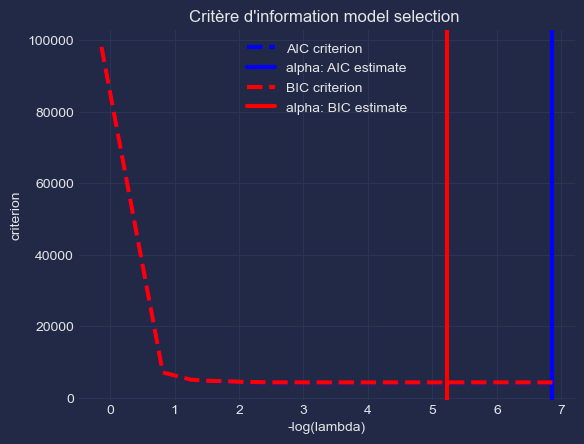

In [116]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from mord import LogisticAT

model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_train, y_train)
alpha_bic_ = model_bic.alpha_






# Variables sélectionnées avec critère BIC
indices_variables_bic = np.where(model_bic.coef_ != 0)[0]
variables_bic = df_train.columns[indices_variables_bic]

# Entraîner le modèle de régression logistique ordinale avec critère BIC
model_ordinal_bic = LogisticAT(alpha=alpha_bic_)
model_ordinal_bic.fit(X_train[:, indices_variables_bic], y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_bic = model_ordinal_bic.predict(X_test[:, indices_variables_bic])

# statistiques bic
r2_bic = r2_score(y_test, y_pred_bic)
mse_bic = mean_squared_error(y_test, y_pred_bic)
accuracy_bic = accuracy_score(y_test, y_pred_bic)




model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_

# Variables sélectionnées avec critère AIC
indices_variables_aic = np.where(model_aic.coef_ != 0)[0]
variables_aic = df_train.columns[indices_variables_aic]

# Entraîner le modèle de régression logistique ordinale avec critère AIC
model_ordinal_aic = LogisticAT(alpha=alpha_aic_)
model_ordinal_aic.fit(X_train[:, list(indices_variables_aic)], y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_aic = model_ordinal_aic.predict(X_test[:, list(indices_variables_aic)])

# statistiques bic
r2_aic = r2_score(y_test, y_pred_aic)
mse_aic = mean_squared_error(y_test, y_pred_aic)
accuracy_aic = accuracy_score(y_test, y_pred_aic)


results = pd.DataFrame({
    "Critère": ["AIC", "BIC"],
    "Variables Sélectionnées": [list(variables_aic), list(variables_bic)],
    "R²": [r2_aic, r2_bic],
    "MSE": [mse_aic, mse_bic],
    "Accuracy model ordinal": [accuracy_aic, accuracy_bic],
    "Alpha (AIC)": [alpha_aic_, np.nan],  # Notez que la valeur de l'alpha pour BIC est obtenue de la même manière
    "Alpha (BIC)": [np.nan, alpha_bic_]
})

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]


results.style.apply(highlight_min, subset=["Alpha (AIC)", "Alpha (BIC)"])




def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    pl.plot(-np.log10(alphas_), criterion_, '--', color=color,
            linewidth=3, label='%s criterion' % name)
    pl.axvline(-np.log10(alpha_), color=color,
              linewidth=3, label='alpha: %s estimate' % name)
    pl.xlabel('-log(lambda)')
    pl.ylabel('criterion')

pl.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
pl.legend()
pl.title("Critère d'information model selection ")


In [125]:
results

,Critère,Variables Sélectionnées,R²,MSE,Accuracy model ordinal,Alpha (AIC),Alpha (BIC)
0,AIC,"[energy_100g, saturated-fat_100g, trans-fat_10...",1.000000,0.000000,1.000000,1.379074e-07,NaN
1,BIC,"[energy_100g, saturated-fat_100g, trans-fat_10...",0.999655,0.000679,0.999321,NaN,0.000006


### Variables sélectionnées

Le meilleur modèle est donné par l'AIC

In [135]:
results["Variables Sélectionnées"][0]

['energy_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g',
 'nutrition-score-fr_100g',
 'code']

In [136]:
model = LogisticAT(alpha=alpha_aic_)
model.fit(X_train[:, list(indices_variables_aic)], y_train)

import pickle

with open(f"../model/modele_ordinal.pkl", 'wb') as model_file:
    pickle.dump(model, model_file)


Re-load du modèle

In [137]:
with open('../model/modele_ordinal.pkl', 'rb') as model_file:
    model_ordinal = pickle.load(model_file)
    
predictions = model_ordinal.predict(X_test[:, indices_variables_aic])
accuracy_ordinal = accuracy_score(y_test, predictions)
print("{:.2f}%".format(accuracy_ordinal * 100))

100.00%
